<a href="https://colab.research.google.com/github/Tottoro932/Neural-networks/blob/main/Lab_2_Mushrooms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Lab_2_1 Mushrooms**

In [1]:
!pip install mxnet

     |████████████████████████████████| 46.9 MB 40 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
# импорт библиотек
import mxnet as mx
from mxnet.gluon.data.vision import transforms

from mxnet import nd, gluon, autograd
from mxnet.gluon import nn

import pickle  # формат для выгрузки данных из памяти на диск и обратно

import numpy as np
import matplotlib.pyplot as plt   # для отображения графиков

In [3]:
# вручную выбираем файл для загрузки (kaggle.json)
from google.colab import files   
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tottoro7","key":"d17e0c62d5cc50816bf506082e885461"}'}

In [4]:
# проверяем, что загрузка произошла успешно
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Sep 24 08:11 kaggle.json


In [5]:
# устанавливаем Kaggle API client
!pip install -q kaggle

In [6]:
# Kaggle API client ожидает, что файл будет находиться в ~/.kaggle,
# так что переместим его туда
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/

In [7]:
# позволяет избежать предупреждений при запуске инструментов Kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              235KB  2021-09-18 20:49:48          12616  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           7663  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           3254  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Women                               838MB  2021-02-28 14:56:00           1431  
dhruvildave/wikibooks-dataset                               Wikibooks Datase

In [9]:
# загрузили датасет из Kaggle
! kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images

 99% 1.84G/1.85G [00:55<00:00, 30.6MB/s]
100% 1.85G/1.85G [00:55<00:00, 35.7MB/s]


In [29]:
# нащи файлы были загружены в формате zip, теперь их необходимо распоковать
!unzip /content/mushrooms.zip -d /content/mushrooms

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0622_axDS6XbWq14.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0623_rGwoTDghdAY.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0624_RmlDHXvJUeU.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0625_zqKe97TlLiA.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0626_Vr79bfyR04Q.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0627_eN6cXmAY_WM.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0628_HgADwtCnaLg.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0629_vlmH59caIwg.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0630_dhxHhToh_80.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0631_PJXNFQZc7n8.jpg  
  inflating: /content/mushrooms/mushrooms/Mushrooms/Boletus/0632_Rc_3hYDbYqU.jpg  
  inflating: /conte

In [30]:
# вычисляет и сверяет криптографические контрольные суммы по алгоритму SHA1
! shalsum /content/mushrooms/Mushrooms/Agaricus/* | sha1sum

/bin/bash: shalsum: command not found
da39a3ee5e6b4b0d3255bfef95601890afd80709  -


In [31]:
! find /content/Mushrooms -type f -print0 | sort -z | xargs -0 sha1sum |sha1sum

find: ‘/content/Mushrooms’: No such file or directory
5cd337198ead0768975610a135e26257153198c7  -


In [32]:
! find /content/mushrooms/Mushrooms -type f -print0 | sort -z | xargs -0 sha1sum |sha1sum

327133579fd126a2e00b29596ffb1e9a52ed8a4a  -


In [28]:
# удаление датасета
! rm -r /content/mushrooms  

In [33]:
ctx = mx.gpu(0) if mx.context.num_gpus() >0 else mx.cpu(0)

In [34]:
! ls /content/mushrooms/Mushrooms   # выводит имена папок

Agaricus  Boletus      Entoloma   Lactarius  Suillus
Amanita   Cortinarius  Hygrocybe  Russula


In [35]:
class_names = ['Agaricus','Amanita','Boletus','Cortinarius','Entoloma','Hygrocybe','Lactarius','Russula','Suillus']

In [82]:
train_data = mx.gluon.data.vision.datasets.ImageFolderDataset('/content/mushrooms/Mushrooms')
test_data = mx.gluon.data.vision.datasets.ImageFolderDataset('/content/mushrooms/mushrooms')

/usr/local/lib/python3.7/dist-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring /content/mushrooms/mushrooms/Mushrooms/Agaricus of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring /content/mushrooms/mushrooms/Mushrooms/Amanita of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring /content/mushrooms/mushrooms/Mushrooms/Boletus of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/data/vision/datasets.py:318: UserWarning: Ignoring /content/mushrooms/mushrooms/Mushrooms/Cortinarius of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))
/usr/local/lib/python3.7/dist-packages/mxnet/gluon/data/vision/datasets

Data type: <class 'numpy.uint8'>
Label: 0
Label description: Agaricus
(600, 800, 3)


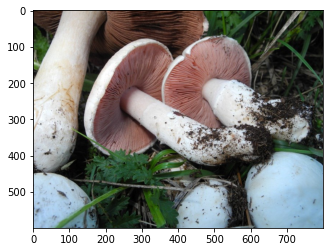

In [83]:
sample_idx = 124
sample = train_data[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy(), cmap = 'Greys')
print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(train_data.synsets[label]))

print(data.shape)

In [84]:
data.shape # выводит размер картинки

(600, 800, 3)

In [50]:
train_data.synsets # выводит названия всех папок

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

In [85]:
# нормализуем изображения
transformer = transforms.Compose([  
    transforms.CenterCrop(550),     
   # transforms.Resize(50,keep_ratio=True),                                                     
    transforms.ToTensor(), 
    transforms.Normalize(0.13, 0.31)]) 

train_data = train_data.transform_first(transformer) 
test_data = test_data.transform_first(transformer)



In [86]:
train_image_no = 10

train_data[train_image_no][0].shape


(3, 550, 550)

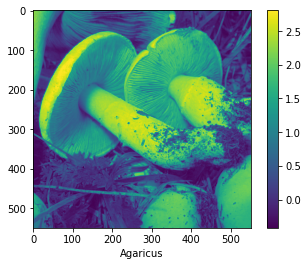

In [87]:
train_image_no = sample_idx  # задаем номер картинки, которую хотим вывести (такой же как и исходной картинки)
 
images_data, label_data = train_data[train_image_no]
plt.figure() 
plt.imshow(images_data.reshape((550,550)).asnumpy())        # выводим картинку на экран, 48 на 48 пикселей
plt.colorbar() 
plt.xlabel(class_names[label_data]) 
plt.show() 


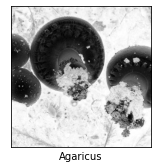

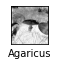

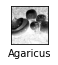

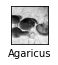

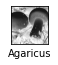

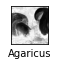

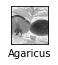

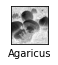

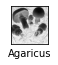

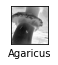

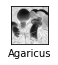

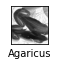

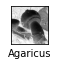

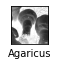

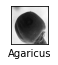

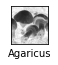

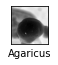

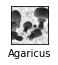

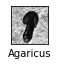

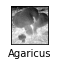

In [88]:
# хотим в табличном виде (15 на 15) показать состав датасета
plt.figure(figsize=(15,15)) # plt - библиотека для рисование графиков
for i in range(20): 
   images_data, label_data = train_data[i] 
   plt.subplot(5,5,i+1) 
   plt.xticks([]) 
   plt.yticks([]) 
   plt.imshow(images_data.reshape((550,550)).asnumpy(), cmap=plt.cm.binary) 
   plt.xlabel(class_names[label_data]) 
   plt.show() 

In [89]:
# создаем модель нейронной сети из 3 последовательных слоев
net = nn.HybridSequential(prefix='MLP_') 
with net.name_scope(): 
   net.add( 
     nn.Flatten(), # переводим в векторную форму
     nn.Dense(128, activation='relu'), # первый слой: 128 нейронов, функция активации (чтобы уйти от линейной зависимости)
     nn.Dense(64, activation='relu'), # второй слой: 128 нейронов, relu: 0 - отриц.при аргументах <0 и само значение при аргументах >0
     nn.Dense(9, activation=None)     # второй слой: 128 нейронов, не содержит активации
   ) 
   # nn - функция mxnet, отвечает за создание нейронных сетей

In [90]:
batch_size = 34 # кол-во картинок, которые мы пропускаем за один раз через сеть во время обучения
train_loader = mx.gluon.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)


In [91]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0) 
net.initialize(mx.init.Xavier(), ctx=ctx)

In [92]:

trainer = gluon.Trainer(                  # trainer проводит оптимизацию параметров
  params=net.collect_params(),            # возвращает параметры net (количество узлов матрицы коэффициентов)
  optimizer='sgd', 
  optimizer_params={'learning_rate': 0.04}, # задали скорость тренировки 0.04
) 

# метрики для отслеживания обучения сети (на сколько хорошо обучается)
metric = mx.metric.Accuracy() # accuracy - точность
loss_function = gluon.loss.SoftmaxCrossEntropyLoss() # функция потерь (на сколько каждая картинка отличается от ожидаемого результата)


In [93]:
# начинаем обучение
num_epochs = 10 # количество эпох (10 раз просматриваем датасет перед тем как завершить обучение)
history = [] 
 
for epoch in range(num_epochs):    # цикл по эпохам
  for inputs, labels in train_loader:   # train_loader - подгрузка данных из датасета порциями
    # Possibly copy inputs and labels to the GPU 
    inputs = inputs.as_in_context(ctx) 
    labels = labels.as_in_context(ctx) 
 
    # Forward pass 
    with autograd.record(): 
      outputs = net(inputs) 
      loss = loss_function(outputs, labels) 
 
    # Backpropagation   # оцениваем функцию потерь и делаем корректировку
    loss.backward() 
    metric.update(labels, outputs) # обновляем метрику (следим за качеством на каждом шаге)
 
    # Update 
    trainer.step(batch_size=inputs.shape[0]) # trainer - следит за состоянием тренировки (обновляем каждый раз)
 
  # Print the evaluation metric and reset it for the next epoch 
  name, acc = metric.get() # точность рассчитывается через метрику
  history.insert(epoch,acc) # на каждом шаге вставляем в массив номер эпохи и текущее значение точности
  print('.', end='') 
  metric.reset() 
 
print('[Done]')

..

KeyboardInterrupt: ignored

Text(0.5, 0, 'Epoch')

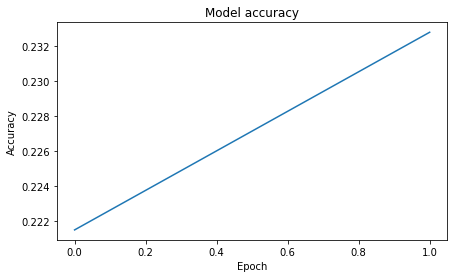

In [94]:
plt.figure(figsize=(7, 4)) 
plt.plot(history) # массив с предыдущего шага
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
# как менялась точность с количеством эпох 


In [95]:
# из тестовых данных подгружаем результаты для проверки качества нашей сети
test_loader = mx.gluon.data.DataLoader(test_data, shuffle=False, batch_size=batch_size) 

In [96]:
# повторям тот же процесс что и при обучении
metric = mx.metric.Accuracy() 
for inputs, labels in test_loader: 
  # Possibly copy inputs and labels to the GPU 
  inputs = inputs.as_in_context(ctx) 
  labels = labels.as_in_context(ctx) 
  metric.update(labels, net(inputs)) 
 
print('Validation: {} = {}'.format(*metric.get()))
# на выходе получаем точность результатов

Validation: accuracy = nan


In [97]:
# Function to display the image: 
def plot_image(predictions_array, true_label, img): 
  plt.xticks([]) 
  plt.yticks([]) 
  plt.imshow(img.reshape((48,48)).asnumpy(), cmap=plt.cm.binary) 
  predicted_label = np.argmax(predictions_array) 
  

  if predicted_label == true_label: 
    color = 'green' 
  else: 
    color = 'red' 
   

  # Print a label with 'predicted class', 'probability %', 'actual class' 
  plt.xlabel("{} [{:2.0f}] ({})".format( 

    class_names[predicted_label], 
    np.max(predictions_array), 
    class_names[true_label]), 

                                  color=color) 
 
# Function to display the prediction results in a graph: 
def plot_value_array(predictions_array, true_label): 
  plt.xticks(range(10)) 
  plt.yticks([]) 
  plot = plt.bar(range(10), predictions_array, color="#777777") 
  predicted_label = np.argmax(predictions_array) 
  plot[predicted_label].set_color('red') 
  plot[true_label].set_color('green')

In [98]:
prediction_image_number = 1  # грузим из тестовых данных элемент с таким номером